<a href="https://colab.research.google.com/github/tanatiem/campaign-response/blob/main/notebooks/campaign_response_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Campaign Response Model

**Task**: Binary Classification

An example classification task to predict whether or not customer will respond to a marketing campaign - Yes/No.

# Import

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
# from lightgbm import early_stopping, log_evaluation

# Load Datasets

| File | Link |
| ---- | ---- |
| Retail_Data_Transactions.csv | https://raw.githubusercontent.com/tanatiem/campaign-response/7ebd38f7728e15fc642bb118c7bfba1e6a103a7c/datasets/Retail_Data_Transactions.csv |
| Retail_Data_Response.csv | https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/Retail_Data_Response.csv |

## Transaction Data

Transactions of customers.  
Each row represents one transaction consisting of;
- `customer_id`: Customer unique identifier
- `trans_date` : Transaction date when the customer made a purchase
- `tran_amount` : The purchase amount



In [5]:
# Load transactions file
trans_url = 'https://raw.githubusercontent.com/tanatiem/campaign-response/7ebd38f7728e15fc642bb118c7bfba1e6a103a7c/datasets/Retail_Data_Transactions.csv'
df_trans = pd.read_csv(trans_url, parse_dates=['trans_date'])
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


Please pardon my OCD 😂 - The column names of `trans_date` and `tran_amount` are not consistent.  
Let's rename `tran_amount` to `trans_amount`

In [6]:
df_trans = df_trans.rename(columns={'tran_amount': 'trans_amount'})
df_trans.head()

,customer_id,trans_date,trans_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


## Response Data

Response for each customer.  
- 1 : Yes = Positive class
- 0 :  No = Negative class

In [7]:
# Load response file (label)
response_url = 'https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/Retail_Data_Response.csv'
df_response = pd.read_csv(response_url)
df_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


In [8]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


## Data Check

In [9]:
# Check duplicates of response data
# Similar to count(*) vs. count(distinct customer_id) in SQL
df_response.shape[0], df_response.customer_id.nunique()

(6884, 6884)

In [10]:
# count distinct of customer_id
df_trans.customer_id.nunique()

6889

Notice that we only have 6,884 customers from response data, but here we have 6,889 customers from transactions data. 

In [11]:
# Valid customer ids = Customer ids that exist in both dataframes.
valid_cust_ids = set(df_response.customer_id.unique()).intersection(df_trans.customer_id.unique())

# Subsetting both
df_trans = df_trans.loc[df_trans.customer_id.isin(valid_cust_ids),:]
df_response = df_response.loc[df_response.customer_id.isin(valid_cust_ids),:]

# Check shapes
print(f"df_trans:    unique cust={df_trans.customer_id.nunique()}, row={df_trans.shape[0]}")
print(f"df_response: unique cust={df_response.customer_id.nunique()}, row={df_response.shape[0]}")

df_trans:    unique cust=6884, row=124969
df_response: unique cust=6884, row=6884


Or you can just simply use `inner join`.

# Exploratory Data Analysis (EDA)

## Response

0    0.906014
1    0.093986
Name: response, dtype: float64


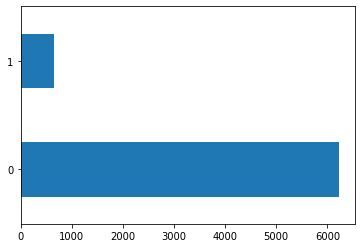

In [12]:
print(df_response.response.value_counts(normalize=True))
df_response.response.value_counts().plot.barh();

10% of Positive class - This is a problem called Imbalance.

## Transaction Amount

In [13]:
df_trans.trans_amount.describe()

count    124969.000000
mean         64.995143
std          22.860059
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: trans_amount, dtype: float64

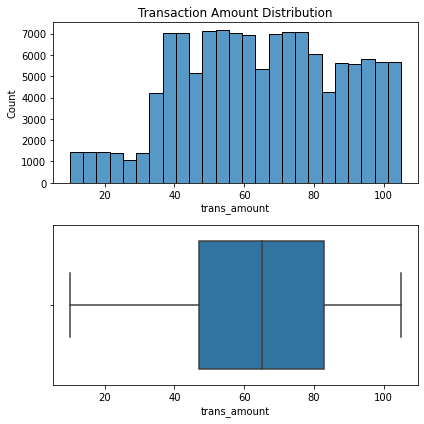

In [14]:
# Transaction amounts distribution
plt.subplots(2,1, figsize=(6,6), tight_layout=True)
plt.subplot(211)
sns.histplot(x='trans_amount', data=df_trans, bins=25)
plt.title('Transaction Amount Distribution')
plt.subplot(212)
sns.boxplot(x='trans_amount', data=df_trans)
plt.show()

### Time-series


In [15]:
# Min & Max of Transation Date
print(f"Min transaction date: {df_trans.trans_date.min()}")
print(f"Max transaction date: {df_trans.trans_date.max()}")

Min transaction date: 2011-05-16 00:00:00
Max transaction date: 2015-03-16 00:00:00


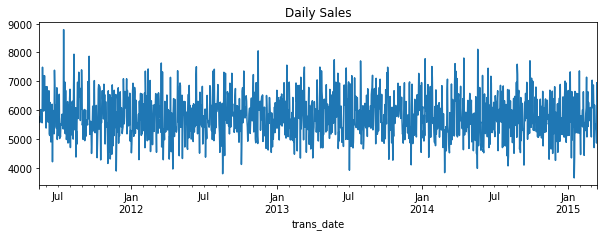

In [16]:
# Let's see how "daily sales" look like
df_trans.groupby('trans_date').trans_amount.sum().plot(title='Daily Sales', figsize=(10,3));

A bit too difficult to read, how about smoothing using simple Moving Average.  
`rolling(window).mean()`

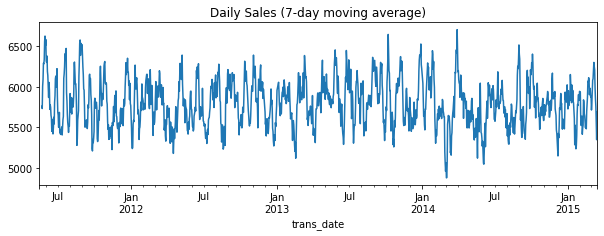

In [17]:
df_trans.groupby('trans_date').trans_amount.sum().rolling(7).mean().plot(title='Daily Sales (7-day moving average)', figsize=(10,3));

Alternatively, we can group by the months of trans_date.  
Also notice that we don't have the whole transactions from the first and last month.
```python 
# A convenient way to group by month
pd.Grouper(key='trans_date', freq='M')
```

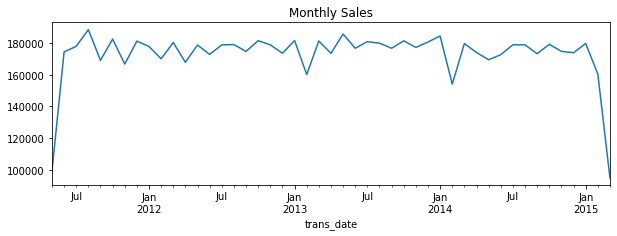

In [18]:
df_trans.groupby(pd.Grouper(key='trans_date', freq='M')).trans_amount.sum().plot(title='Monthly Sales', figsize=(10,3));

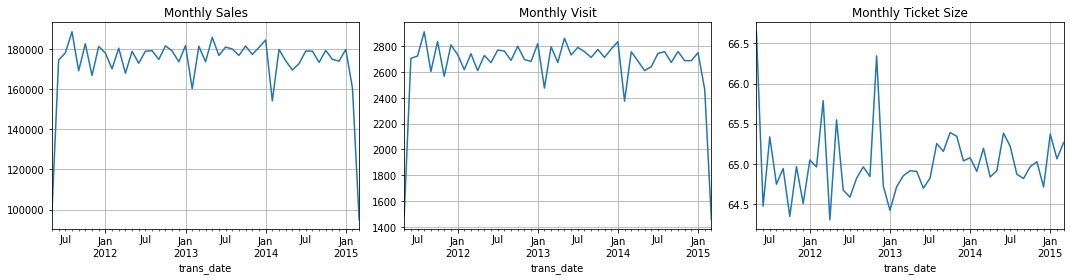

In [19]:
fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=True)

df_trans.groupby(pd.Grouper(key='trans_date',freq='M')).trans_amount.sum().plot(title='Monthly Sales', ax=axes[0])
# visit or number of baskets/transactions
df_trans.groupby(pd.Grouper(key='trans_date',freq='M')).trans_amount.size().plot(title='Monthly Visit', ax=axes[1])
# ticket size = total sales amount divided by number of transactions for each month
df_trans.groupby(pd.Grouper(key='trans_date',freq='M')).trans_amount.apply(lambda x: x.sum()/x.count()).plot(title='Monthly Ticket Size')
for ax in axes:
    ax.grid(True)
plt.show()

## Cohort Analysis

Step by Step of how to create a cohort visualization.  

In [20]:
# Group transactions by customer_id and transaction "Month"
cohort = df_trans.groupby(['customer_id', pd.Grouper(key='trans_date', freq='M')], as_index=False).size()
# Rename trans_date to trans_month
cohort = cohort.rename(columns={'trans_date':'trans_month'})
cohort

,customer_id,trans_month,size
0,CS1112,2011-06-30,1
1,CS1112,2011-08-31,1
2,CS1112,2011-10-31,1
3,CS1112,2012-04-30,1
4,CS1112,2012-06-30,1
...,...,...,...
103203,CS9000,2014-01-31,1
103204,CS9000,2014-05-31,1
103205,CS9000,2014-07-31,1
103206,CS9000,2014-08-31,1


In [21]:
# Create a column to store start_month for each customer, we will use this in the later calculation
cohort['start_month'] = cohort.groupby('customer_id').trans_month.transform('min')

# Calculate the difference in months from start_month to trans_date.
cohort['month'] = cohort.apply(lambda x: (x.trans_month.year - x.start_month.year)*12 + 
                               (x.trans_month.month - x.start_month.month) , axis=1)

cohort.head(20)

,customer_id,trans_month,size,start_month,month
0,CS1112,2011-06-30,1,2011-06-30,0
1,CS1112,2011-08-31,1,2011-06-30,2
2,CS1112,2011-10-31,1,2011-06-30,4
3,CS1112,2012-04-30,1,2011-06-30,10
4,CS1112,2012-06-30,1,2011-06-30,12
5,CS1112,2012-07-31,1,2011-06-30,13
6,CS1112,2012-09-30,1,2011-06-30,15
7,CS1112,2012-12-31,1,2011-06-30,18
8,CS1112,2013-03-31,1,2011-06-30,21
9,CS1112,2013-07-31,1,2011-06-30,25


Pivot the dataframe. 

In [22]:
cohort = pd.pivot_table(cohort, index='start_month', columns='month', values='customer_id', aggfunc='count').sort_index()
cohort.head()

month,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
start_month,,,,,,,,,,,,,,,,,,,,,
2011-05-31,1343.0,426.0,460.0,491.0,448.0,489.0,402.0,458.0,457.0,445.0,...,457.0,477.0,441.0,438.0,465.0,433.0,425.0,460.0,411.0,262.0
2011-06-30,1804.0,580.0,612.0,580.0,607.0,563.0,586.0,607.0,567.0,632.0,...,592.0,623.0,561.0,579.0,586.0,606.0,577.0,520.0,325.0,NaN
2011-07-31,1214.0,416.0,413.0,425.0,387.0,424.0,390.0,387.0,397.0,391.0,...,403.0,391.0,397.0,406.0,381.0,433.0,374.0,208.0,NaN,NaN
2011-08-31,862.0,265.0,279.0,259.0,283.0,293.0,282.0,277.0,264.0,301.0,...,256.0,276.0,292.0,308.0,272.0,289.0,181.0,NaN,NaN,NaN
2011-09-30,467.0,133.0,139.0,169.0,168.0,142.0,150.0,150.0,144.0,129.0,...,171.0,150.0,147.0,144.0,133.0,97.0,NaN,NaN,NaN,NaN


`Column 0`: is the starting month.   
`Column N`: is the n-th month from starting month.  

Let's look at the first cohort (`2011-05-31`). There are `1,344` customers made their first purchases in May 2011. Among the customers from this cohort, `426` customers made their purchases again in the next month (Column `1`). And there are `491` customers made the purchases 3 months after join.
  
  
But raw counts are a bit difficult to interpret, seeing the percentage is way easier.  
Instead, let's convert them into percentages.

In [23]:
# normalize number of customers for each month - dividing by # of cust in the starting month for each cohort
cohort = cohort.divide(cohort.iloc[:,0], axis=0).multiply(100)
# format the index
cohort.index = cohort.index.strftime('%Y-%m')
cohort.head()

month,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
start_month,,,,,,,,,,,,,,,,,,,,,
2011-05,100.0,31.720030,34.251675,36.559940,33.358153,36.411020,29.932986,34.102755,34.028295,33.134773,...,34.028295,35.517498,32.836932,32.613552,34.623976,32.241251,31.645570,34.251675,30.603127,19.508563
2011-06,100.0,32.150776,33.924612,32.150776,33.647450,31.208426,32.483370,33.647450,31.430155,35.033259,...,32.815965,34.534368,31.097561,32.095344,32.483370,33.592018,31.984479,28.824834,18.015521,NaN
2011-07,100.0,34.266886,34.019769,35.008237,31.878089,34.925865,32.125206,31.878089,32.701812,32.207578,...,33.196046,32.207578,32.701812,33.443163,31.383855,35.667216,30.807249,17.133443,NaN,NaN
2011-08,100.0,30.742459,32.366589,30.046404,32.830626,33.990719,32.714617,32.134571,30.626450,34.918794,...,29.698376,32.018561,33.874710,35.730858,31.554524,33.526682,20.997680,NaN,NaN,NaN
2011-09,100.0,28.479657,29.764454,36.188437,35.974304,30.406852,32.119914,32.119914,30.835118,27.623126,...,36.616702,32.119914,31.477516,30.835118,28.479657,20.770878,NaN,NaN,NaN,NaN


We can interpret this percentage count as **Retention Rate** for each cohort.  

Now's the time to visualize.

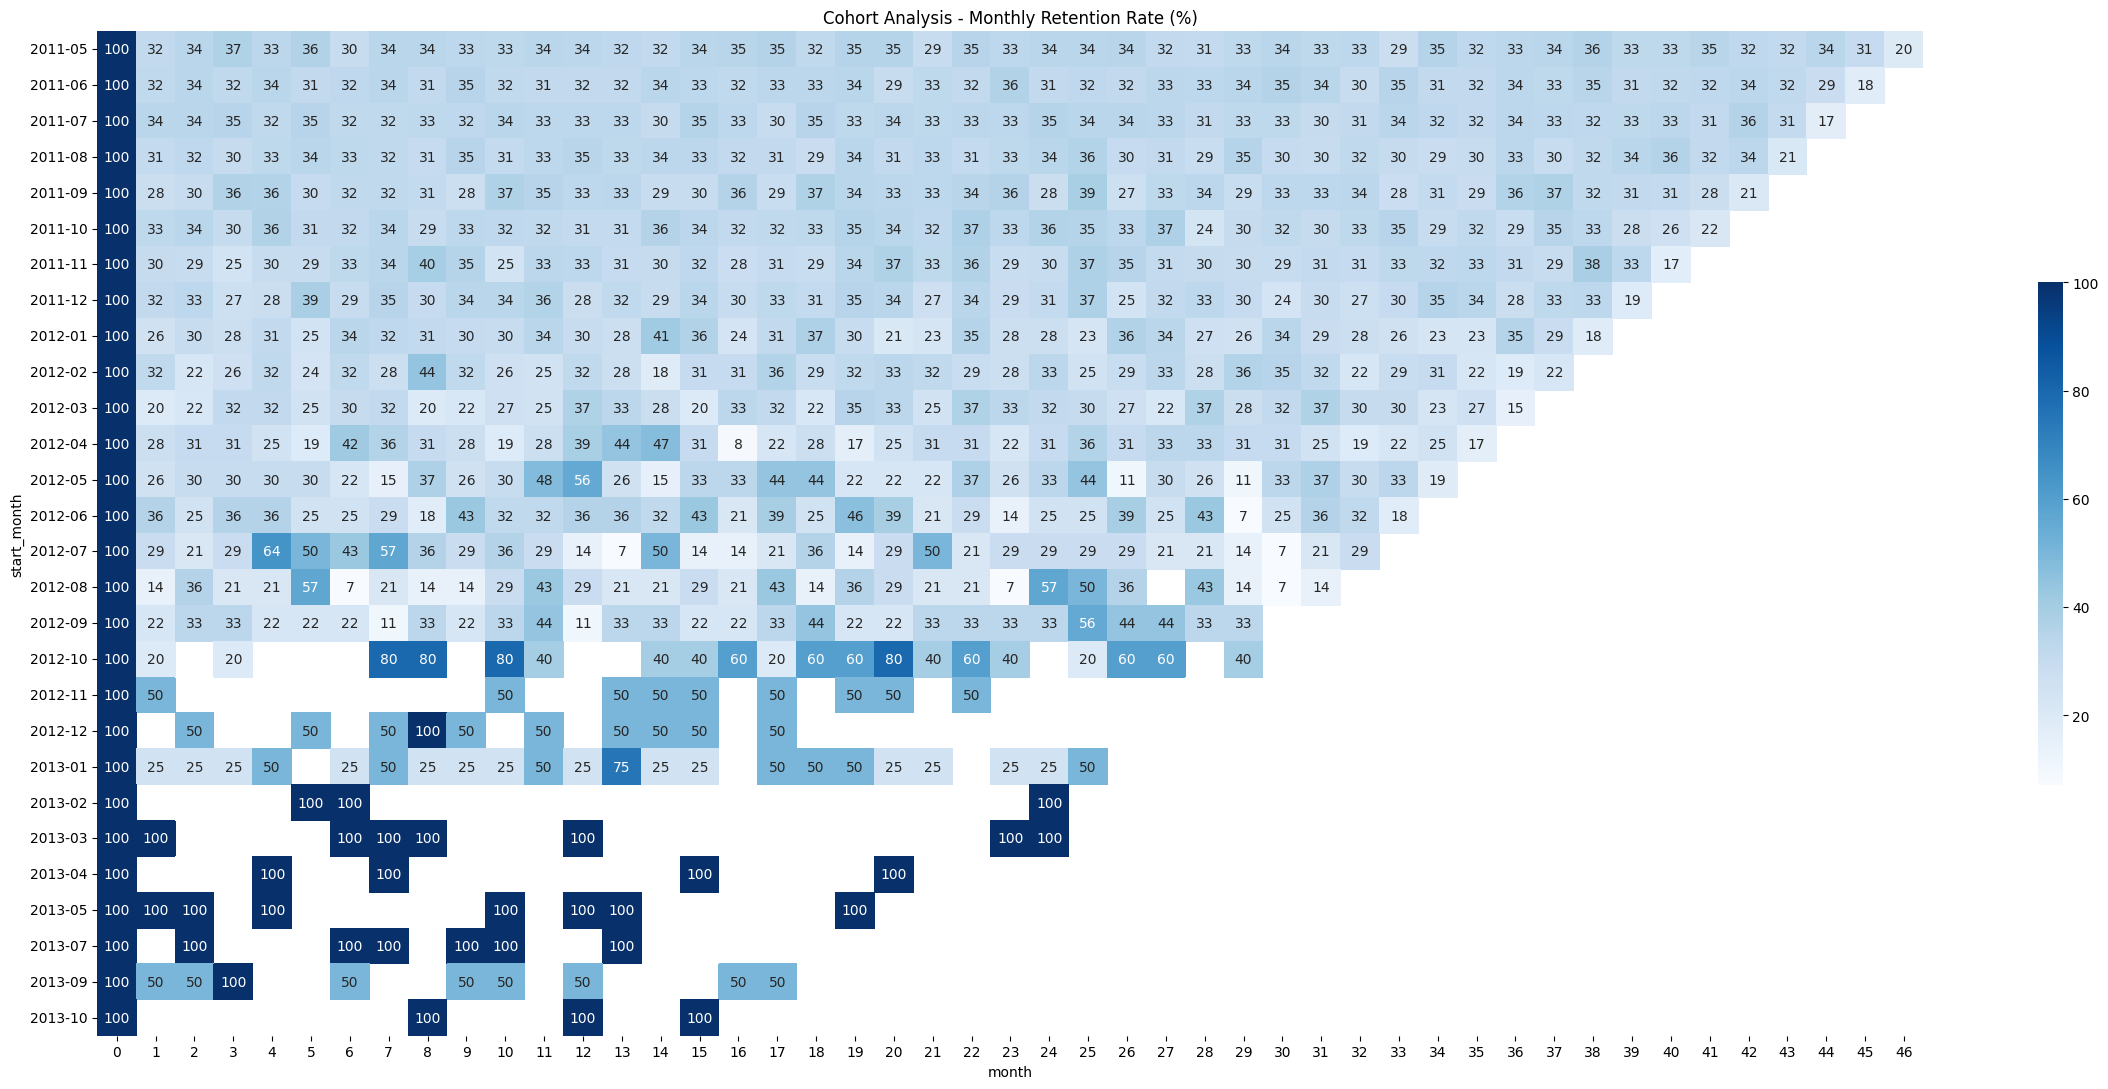

In [24]:
plt.figure(figsize=(24,11), dpi=100, tight_layout=True)
sns.heatmap(cohort, cmap='Blues', annot=True, fmt='.0f', cbar_kws={'shrink':.5})
plt.title('Cohort Analysis - Monthly Retention Rate (%)', fontsize=12);
plt.savefig('cohort.png', bbox_inches="tight")

# Feature Engineering

In order to make a prediction model to predict whether a "customer" will response to our campaign or not. We have to create variables or features that represents data on customer level.

Our transaction data is currently on the transaction level that one customer can have many transactions. We need to `aggregate` information to customer level.  

This will be a quick tour to `pandas`' capabilities in transforming and aggregating data.

In [25]:
# the last transaction date
df_trans.trans_date.max()

Timestamp('2015-03-16 00:00:00')

In [26]:
# Let's say, we'll do the campaign on 2015-03-17
campaign_date = datetime(2015,3,17)

# transaction age = # of days from trans_date to campaign_date
df_trans['age'] = (campaign_date - df_trans.trans_date).dt.days

df_trans.head()

,customer_id,trans_date,trans_amount,age
0,CS5295,2013-02-11,35,764
1,CS4768,2015-03-15,39,2
2,CS2122,2013-02-26,52,749
3,CS1217,2011-11-16,99,1217
4,CS1850,2013-11-20,78,482


## RFM features

Recency-Frequency-Monetary is a common practice to extract information from transaction data like this.

- **R: Recency**  
Recency is how recent a customer interact with us. Basically duration of the last transaction to today or the campaign date.

- **F: Frequency**  
Frequency is how many times a customer made their purchases. Basically the number of transactions for each customer.

- **M: Monetary**  
Monetary is how much a customer spend. Basically the sum of all transaction amounts.  

- **T: Tenure**  
Tenure is how long a customer is with us. Basically how long since the first transaction or the value of the max transaction age.  

### Recency

One way to calculate this is to find the minimum transaction age for each customer.



In [27]:
# group transactions by customer_id and find min of transaction age for each customer_id
df_trans.groupby('customer_id').age.min().head()

customer_id
CS1112     62
CS1113     36
CS1114     33
CS1115     12
CS1116    204
Name: age, dtype: int64

### Frequency
The number of transaction for each customer.

In [28]:
# same as df_trans.groupby('customer_id').size(), you can count any non-null column
df_trans.groupby('customer_id').customer_id.count().head()

customer_id
CS1112    15
CS1113    20
CS1114    19
CS1115    22
CS1116    13
Name: customer_id, dtype: int64

### Monetary
The sum of transaction amounts for each customer.

In [29]:
df_trans.groupby('customer_id').trans_amount.sum().head()

customer_id
CS1112    1012
CS1113    1490
CS1114    1432
CS1115    1659
CS1116     857
Name: trans_amount, dtype: int64

### Tenure

Similar to Recency, Tenure is the duration from the first transaction instead of the last one like Recency. So basically, maximum transaction age for each customer.

In [30]:
df_trans.groupby('customer_id').age.max().head()

customer_id
CS1112    1371
CS1113    1390
CS1114    1342
CS1115    1315
CS1116    1359
Name: age, dtype: int64

### RFM in one go

A convenient way to do all the above-mentioned features. Pretty neat!  
```monetary=('trans_amount', 'sum')```
means sum of tran_amounts grouped by customer_id, then name this column as monetary.

In [31]:
# addditional feature: length_of_stay
df = df_trans.groupby('customer_id').agg(
    recency=('age', 'min'),
    frequency=('customer_id', 'count'),
    monetary=('trans_amount', 'sum'),
    tenure=('age', 'max'),
    length_of_stay=('age', lambda x: x.max() - x.min())
)
df.head()

,recency,frequency,monetary,tenure,length_of_stay
customer_id,,,,,
CS1112,62,15,1012,1371,1309
CS1113,36,20,1490,1390,1354
CS1114,33,19,1432,1342,1309
CS1115,12,22,1659,1315,1303
CS1116,204,13,857,1359,1155


## Ticket Size

How much does a customer spend per visit? 
Ticket size is equal to Total Spend divided by Total Visit.  
It's the same as $\frac{Monetary}{Frequency}$

In [32]:
df['ticket_size'] = df.monetary / df.frequency
df.head()

,recency,frequency,monetary,tenure,length_of_stay,ticket_size
customer_id,,,,,,
CS1112,62,15,1012,1371,1309,67.466667
CS1113,36,20,1490,1390,1354,74.500000
CS1114,33,19,1432,1342,1309,75.368421
CS1115,12,22,1659,1315,1303,75.409091
CS1116,204,13,857,1359,1155,65.923077


Ticket size is also the same value as the average of transaction amount.  
And since we are going to calculate the `mean` of `tran_amount`, why not try the standard deviation as well (`std`).  

Standard Deviation of transaction amounts can tell you how consistent their transactions are.  
For example,  
*Customer A*: `[10, 10, 10, 10]`. Mean = 10 and std = 0.  
*Customer B*: `[34,  2,  2,  2]`. Mean = 10 and std = 13.86.



In [33]:
df['std_ticket_size'] = df_trans.groupby('customer_id').trans_amount.std()
df.head()

,recency,frequency,monetary,tenure,length_of_stay,ticket_size,std_ticket_size
customer_id,,,,,,,
CS1112,62,15,1012,1371,1309,67.466667,19.766012
CS1113,36,20,1490,1390,1354,74.500000,21.254102
CS1114,33,19,1432,1342,1309,75.368421,21.341692
CS1115,12,22,1659,1315,1303,75.409091,18.151896
CS1116,204,13,857,1359,1155,65.923077,22.940000


### Coefficient of Variation

Raw standard deviation may not be a good measure to compare against other customers. For example,  
Customer A - Amounts:  $\mu = 100, \sigma = 5$  
Customer B - Amounts: $\mu = 10, \sigma = 5$  

For Customer A, the variation of 5 compared to average ticket size of 100 is just 5%. But for Customer B, the variation is 50%.

Let us try to create a new feature called Coefficient of Variant.  
$$cv = \frac{\sigma}{\mu}$$


In [34]:
df['cv_ticket_size'] = df.std_ticket_size / df.ticket_size
df.head()

,recency,frequency,monetary,tenure,length_of_stay,ticket_size,std_ticket_size,cv_ticket_size
customer_id,,,,,,,,
CS1112,62,15,1012,1371,1309,67.466667,19.766012,0.292974
CS1113,36,20,1490,1390,1354,74.500000,21.254102,0.285290
CS1114,33,19,1432,1342,1309,75.368421,21.341692,0.283165
CS1115,12,22,1659,1315,1303,75.409091,18.151896,0.240712
CS1116,204,13,857,1359,1155,65.923077,22.940000,0.347981


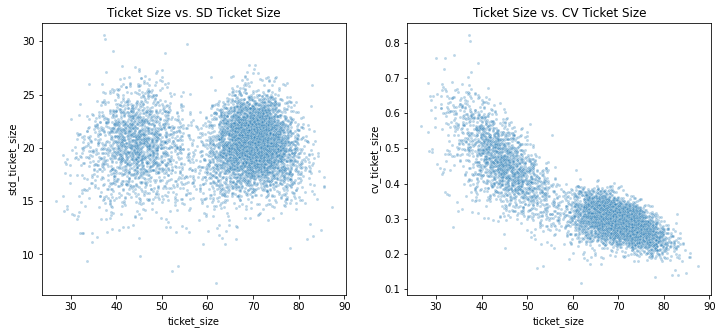

In [35]:
plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)
sns.scatterplot(data=df, x='ticket_size', y='std_ticket_size', alpha=.3, marker='.')
plt.title('Ticket Size vs. SD Ticket Size')
plt.subplot(122)
sns.scatterplot(data=df, x='ticket_size', y='cv_ticket_size', alpha=.3, marker='.')
plt.title('Ticket Size vs. CV Ticket Size')
plt.show()

The more ticket_size, the less percentage of variation.

## Average Spend and Visit per month
```
Monthly spend = Total spend / Number of months visited
Monthly visit = Total visit / Number of months visited

Total spend = Monetary
Total visit = Frequency
```

In [36]:
# We'll make a column for Transaction Month, so that we can count the number of months that a customer visits
# No matter the date of trans_date is, it will replaced with the 1st day of month
df_trans['trans_month'] = df_trans.trans_date + pd.offsets.MonthBegin(-1)
df_trans.head()

,customer_id,trans_date,trans_amount,age,trans_month
0,CS5295,2013-02-11,35,764,2013-02-01
1,CS4768,2015-03-15,39,2,2015-03-01
2,CS2122,2013-02-26,52,749,2013-02-01
3,CS1217,2011-11-16,99,1217,2011-11-01
4,CS1850,2013-11-20,78,482,2013-11-01


In [37]:
# Now we count the number of unique month for each customer
active_months = df_trans.groupby('customer_id').trans_month.nunique()
active_months

customer_id
CS1112    15
CS1113    18
CS1114    14
CS1115    19
CS1116    13
          ..
CS8996    10
CS8997    13
CS8998    12
CS8999    12
CS9000    11
Name: trans_month, Length: 6884, dtype: int64

In [38]:
df['active_months'] = active_months
df['avg_spend_m'] = df.monetary / df.active_months
df['avg_visit_m'] = df.frequency / df.active_months
# done with active_months, then drop it
df = df.drop(columns='active_months')
df.head()

,recency,frequency,monetary,tenure,length_of_stay,ticket_size,std_ticket_size,cv_ticket_size,avg_spend_m,avg_visit_m
customer_id,,,,,,,,,,
CS1112,62,15,1012,1371,1309,67.466667,19.766012,0.292974,67.466667,1.000000
CS1113,36,20,1490,1390,1354,74.500000,21.254102,0.285290,82.777778,1.111111
CS1114,33,19,1432,1342,1309,75.368421,21.341692,0.283165,102.285714,1.357143
CS1115,12,22,1659,1315,1303,75.409091,18.151896,0.240712,87.315789,1.157895
CS1116,204,13,857,1359,1155,65.923077,22.940000,0.347981,65.923077,1.000000


## Time to Event

Time to event or Time between transactions. Another way to tell that how often this customer visit us.  
Low TTE  = Visit often

- First calculate the duration between transactions in days
- Aggregate durations with Mean and Standard Deviation.

In [39]:
# We will find the duration for each transaction, first sort df_trans by customer_id and trans_date
df_tte = df_trans[['customer_id','trans_date']].sort_values(['customer_id','trans_date'])

# find previous date for each day
# the first transaction doesn't have its predecessor.
df_tte['prev_date'] = df_tte.groupby('customer_id')['trans_date'].shift(1)

# calculate duration in days between each transaction and its previous one.
df_tte['duration'] = (df_tte['trans_date'] - df_tte['prev_date']).dt.days
df_tte.head(20)

,customer_id,trans_date,prev_date,duration
77247,CS1112,2011-06-15,NaT,NaN
89149,CS1112,2011-08-19,2011-06-15,65.0
68206,CS1112,2011-10-02,2011-08-19,44.0
36486,CS1112,2012-04-08,2011-10-02,189.0
93074,CS1112,2012-06-24,2012-04-08,77.0
67735,CS1112,2012-07-03,2012-06-24,9.0
89734,CS1112,2012-09-16,2012-07-03,75.0
40368,CS1112,2012-12-15,2012-09-16,90.0
87839,CS1112,2013-03-01,2012-12-15,76.0
42084,CS1112,2013-07-01,2013-03-01,122.0


In [40]:
df_tte = df_tte.groupby('customer_id').agg(avg_tte=('duration','mean'),
                                           std_tte=('duration','std'))
df_tte['cv_tte'] = df_tte.std_tte / df_tte.avg_tte
df_tte.head()

,avg_tte,std_tte,cv_tte
customer_id,,,
CS1112,93.500000,50.873523,0.544102
CS1113,71.263158,54.685812,0.767378
CS1114,72.722222,73.693168,1.013351
CS1115,62.047619,55.413425,0.893079
CS1116,96.250000,107.361010,1.115439


In [41]:
# join with our main dataframe
df = df.join(df_tte)
df.head()

,recency,frequency,monetary,tenure,length_of_stay,ticket_size,std_ticket_size,cv_ticket_size,avg_spend_m,avg_visit_m,avg_tte,std_tte,cv_tte
customer_id,,,,,,,,,,,,,
CS1112,62,15,1012,1371,1309,67.466667,19.766012,0.292974,67.466667,1.000000,93.500000,50.873523,0.544102
CS1113,36,20,1490,1390,1354,74.500000,21.254102,0.285290,82.777778,1.111111,71.263158,54.685812,0.767378
CS1114,33,19,1432,1342,1309,75.368421,21.341692,0.283165,102.285714,1.357143,72.722222,73.693168,1.013351
CS1115,12,22,1659,1315,1303,75.409091,18.151896,0.240712,87.315789,1.157895,62.047619,55.413425,0.893079
CS1116,204,13,857,1359,1155,65.923077,22.940000,0.347981,65.923077,1.000000,96.250000,107.361010,1.115439


## Past-X-Year Features

The features that we just made so far can be called `Life To Date` features because we use all the data regardless of how old it is. Customers can change their behavior over time. Sometimes using only recent data to generate features yeild a batter result.

We will make features the same way we just did but using only past 1 and 2 years data. We can filter the transactions using transaction date.

In [42]:
# Our max transactions date are in the middle of the month
print(f"Max transaction date: {df_trans.trans_date.max()}")

# We count back 1 year starting from 2015-03-01
print(f"Past 1 Year  criteria: trans_date >= {df_trans.trans_date.max().replace(day=1) - relativedelta(years=1)}")
print(f"Past 2 Years criteria: trans_date >= {df_trans.trans_date.max().replace(day=1) - relativedelta(years=2)}")

Max transaction date: 2015-03-16 00:00:00
Past 1 Year  criteria: trans_date >= 2014-03-01 00:00:00
Past 2 Years criteria: trans_date >= 2013-03-01 00:00:00


In [43]:
# Generate RFM & Time to Event features for each past X years
to_date = df_trans.trans_date.max().replace(day=1)

periods = [1,2]
for n in periods:
    df_trans_cut = df_trans[df_trans.trans_date >= to_date - relativedelta(years=n)].sort_values(['customer_id','trans_date'])
    df_trans_cut['prev_date'] = df_trans_cut.groupby('customer_id').trans_date.shift(1)
    df_trans_cut['duration'] = (df_trans_cut['trans_date'] - df_trans_cut['prev_date']).dt.days

    df_pastyear = df_trans_cut.groupby('customer_id')['trans_amount'].agg([(f'monetary_{n}y','sum'), 
                                                            (f'frequency_{n}y','size'), 
                                                            (f'ticket_size_{n}y', 'mean'), 
                                                            (f'std_ticket_size_{n}y','std'),
                                                            (f'cv_ticket_size_{n}y', lambda x: x.std()/x.mean())
                                                            ])
    df_pastyear = df_pastyear.join(df_trans_cut.groupby('customer_id')['duration'].agg([(f'avg_tte_{n}y', 'mean'), 
                                                            (f'std_tte_{n}y', 'std'),
                                                            (f'cv_tte_{n}y', lambda x: x.std()/x.mean())
                                                            ]))
    df = df.join(df_pastyear, how='left').fillna(0)

df.head()

,recency,frequency,monetary,tenure,length_of_stay,ticket_size,std_ticket_size,cv_ticket_size,avg_spend_m,avg_visit_m,...,std_tte_1y,cv_tte_1y,monetary_2y,frequency_2y,ticket_size_2y,std_ticket_size_2y,cv_ticket_size_2y,avg_tte_2y,std_tte_2y,cv_tte_2y
customer_id,,,,,,,,,,,,,,,,,,,,,
CS1112,62,15,1012,1371,1309,67.466667,19.766012,0.292974,67.466667,1.000000,...,50.560195,0.583387,463,7,66.142857,25.195427,0.380924,114.000000,46.190908,0.405183
CS1113,36,20,1490,1390,1354,74.500000,21.254102,0.285290,82.777778,1.111111,...,65.434700,1.105316,872,12,72.666667,24.031545,0.330709,64.090909,56.728220,0.885121
CS1114,33,19,1432,1342,1309,75.368421,21.341692,0.283165,102.285714,1.357143,...,44.002841,1.066736,804,11,73.090909,24.010225,0.328498,62.600000,64.740851,1.034199
CS1115,12,22,1659,1315,1303,75.409091,18.151896,0.240712,87.315789,1.157895,...,123.987903,1.041915,831,11,75.545455,15.577956,0.206206,71.500000,71.019950,0.993286
CS1116,204,13,857,1359,1155,65.923077,22.940000,0.347981,65.923077,1.000000,...,37.740341,0.721153,333,5,66.600000,25.234896,0.378902,49.750000,31.245000,0.628040


# Feature EDA

## Join with the response variable

`join()` uses indexes from both DataFrame as the key.  So we're gonna make our `df_response` like this when joined.

In [44]:
df_response.set_index('customer_id').head()

,response
customer_id,
CS1112,0
CS1113,0
CS1114,1
CS1115,1
CS1116,1


In [45]:
all_data = df_response.set_index('customer_id').join(df, how='inner')
print(all_data.shape)
all_data.head()

(6884, 30)


,response,recency,frequency,monetary,tenure,length_of_stay,ticket_size,std_ticket_size,cv_ticket_size,avg_spend_m,...,std_tte_1y,cv_tte_1y,monetary_2y,frequency_2y,ticket_size_2y,std_ticket_size_2y,cv_ticket_size_2y,avg_tte_2y,std_tte_2y,cv_tte_2y
customer_id,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1371,1309,67.466667,19.766012,0.292974,67.466667,...,50.560195,0.583387,463,7,66.142857,25.195427,0.380924,114.000000,46.190908,0.405183
CS1113,0,36,20,1490,1390,1354,74.500000,21.254102,0.285290,82.777778,...,65.434700,1.105316,872,12,72.666667,24.031545,0.330709,64.090909,56.728220,0.885121
CS1114,1,33,19,1432,1342,1309,75.368421,21.341692,0.283165,102.285714,...,44.002841,1.066736,804,11,73.090909,24.010225,0.328498,62.600000,64.740851,1.034199
CS1115,1,12,22,1659,1315,1303,75.409091,18.151896,0.240712,87.315789,...,123.987903,1.041915,831,11,75.545455,15.577956,0.206206,71.500000,71.019950,0.993286
CS1116,1,204,13,857,1359,1155,65.923077,22.940000,0.347981,65.923077,...,37.740341,0.721153,333,5,66.600000,25.234896,0.378902,49.750000,31.245000,0.628040


## Descriptive Stats

In [46]:
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
response,6884.0,0.093986,0.291831,0.000000,0.000000,0.000000,0.000000,1.000000
recency,6884.0,81.024985,83.251016,1.000000,23.000000,54.000000,112.000000,679.000000
frequency,6884.0,18.153544,5.184476,4.000000,14.000000,18.000000,22.000000,39.000000
monetary,6884.0,1179.892214,465.421365,149.000000,781.000000,1228.000000,1520.250000,2933.000000
tenure,6884.0,1322.488379,84.553118,507.000000,1295.000000,1348.500000,1381.000000,1401.000000
length_of_stay,6884.0,1241.463393,120.923405,420.000000,1188.000000,1271.000000,1326.250000,1400.000000
ticket_size,6884.0,63.093408,12.427716,26.700000,52.679825,67.708333,72.009615,87.400000
std_ticket_size,6884.0,20.296730,2.468658,7.359801,18.784567,20.406936,21.942726,30.554596
cv_ticket_size,6884.0,0.337573,0.093071,0.119026,0.276991,0.308837,0.369242,0.820258
avg_spend_m,6884.0,76.504801,18.627924,29.666667,61.783730,80.500000,89.813920,139.666667


## Histograms

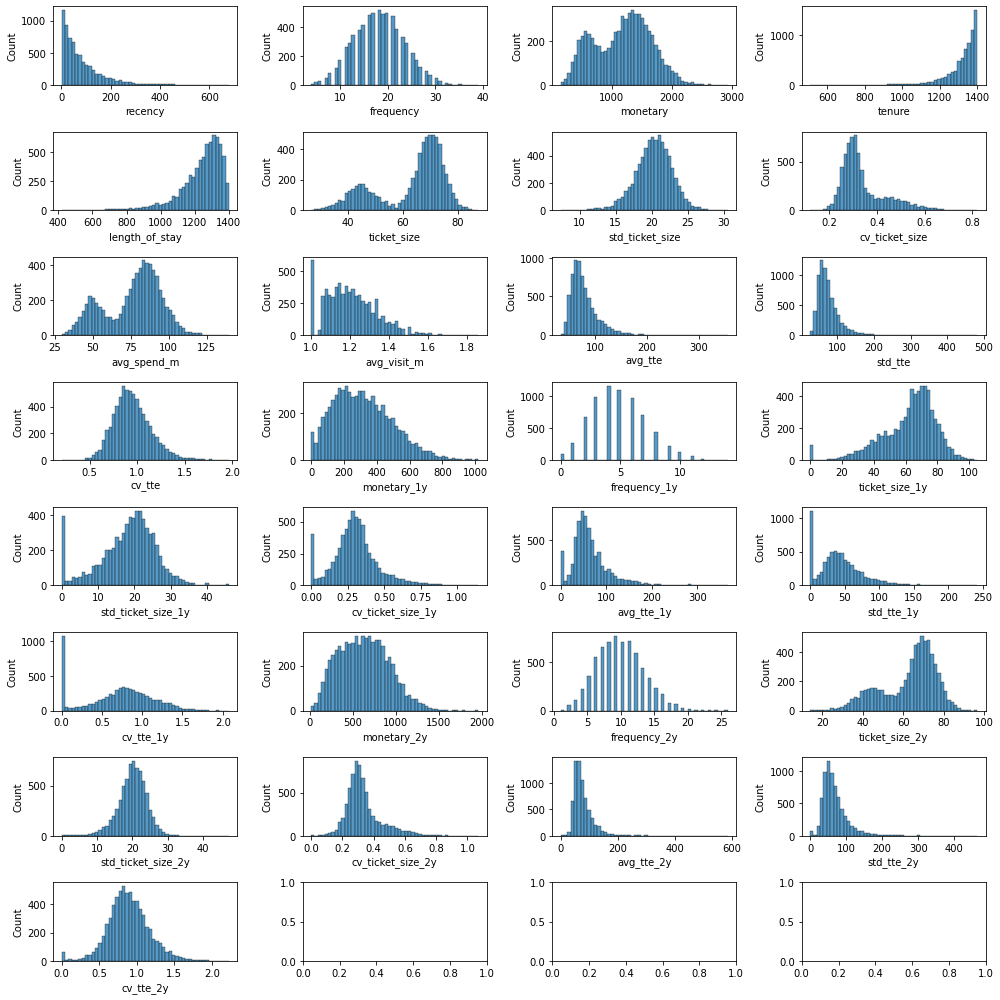

In [47]:
data = all_data.drop(columns='response')

n_cols = 4
n_rows, mod = divmod(len(data.columns), n_cols)
n_rows += int(mod > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(data.columns, axes):
    sns.histplot(data[col], ax=ax, bins=50)
plt.show()

## Boxen Plots

Now let's compare distributions between respondent and non-respondent for each variable.

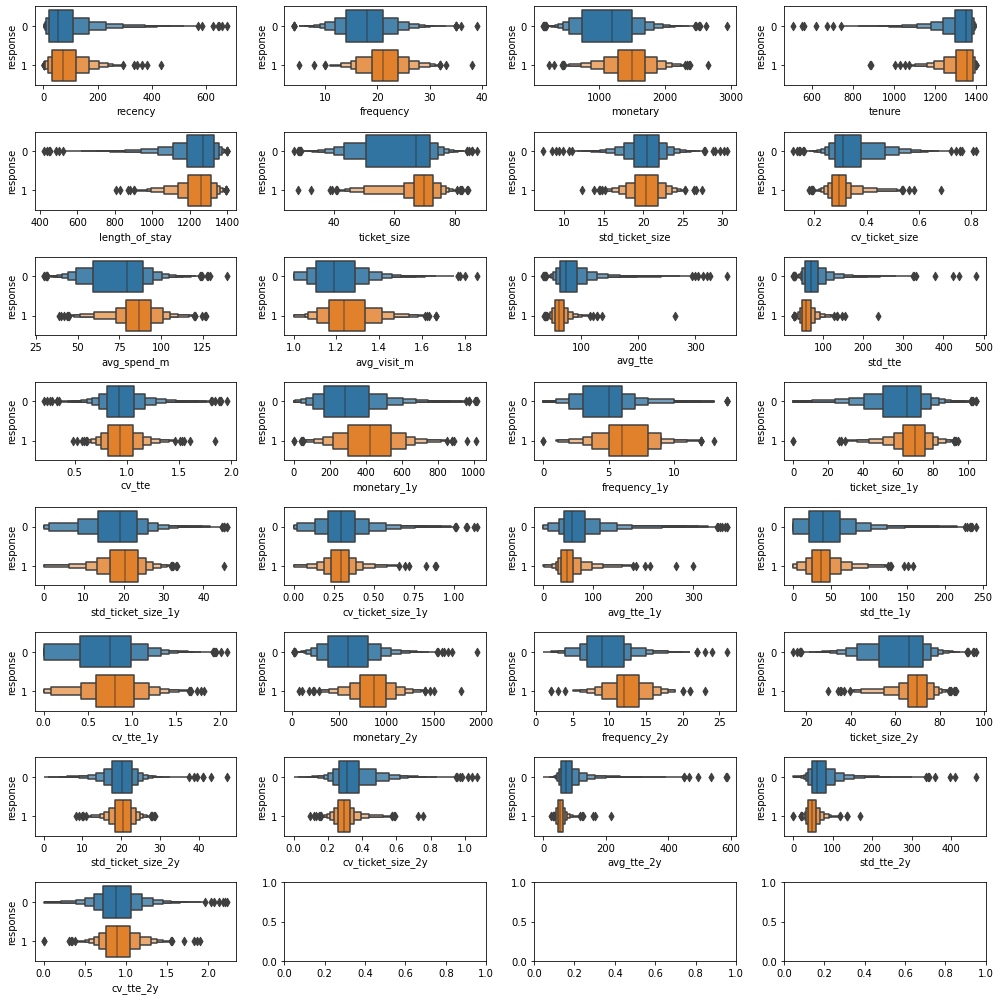

In [48]:
# using response value
data = all_data

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*1.75), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(data.columns[1:], axes):
    sns.boxenplot(data=data, y='response', x=col, ax=ax, orient='h')
plt.show()

## Correlogram

Explore correlations between features.

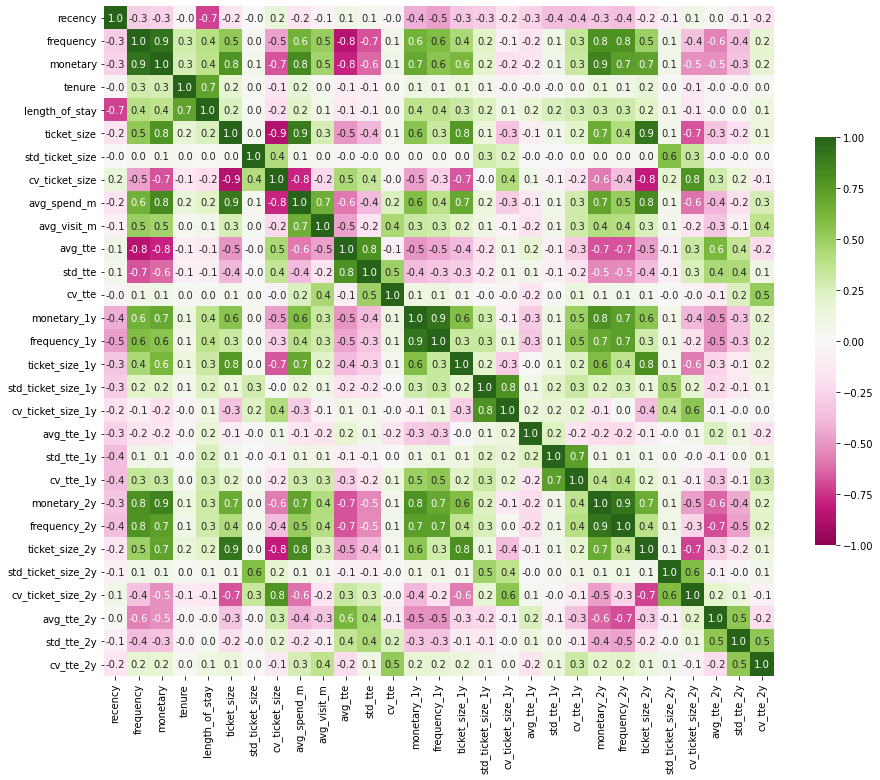

In [49]:
plt.figure(figsize=(15,15))
sns.heatmap(all_data.drop(columns='response').corr(), cmap='PiYG', annot=True, fmt='.1f', vmin=-1, vmax=1,
            square=True, cbar_kws={"shrink": 0.5} );

# Train/Test preparation

In [50]:
# เลขท้าย 2 ตัวงวดที่แล้ว
random_state = 61

test_size = 0.2

X = all_data.copy()
y = X.pop('response')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

print(f"Train:      {len(train_data)} {len(train_data)/len(all_data):.3%}, pos class: {y_train.mean():.2%}")
print(f"Test:       {len(test_data)} {len(test_data)/len(all_data):.3%}, pos class: {y_test.mean():.2%}")

Train:      5507 79.997%, pos class: 9.41%
Test:       1377 20.003%, pos class: 9.37%


# Mutual Information

We can use Mutual information for feature selection.  
You can read more at https://www.kaggle.com/code/ryanholbrook/mutual-information

In [51]:
# Mutual Information Score Helpers
def get_mi_scores(X, y, discrete_features='auto'): 
	mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=random_state)
	mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
	mi_scores = mi_scores.sort_values(ascending=False)
	return mi_scores

def plot_mi_scores(mi_scores, figsize=(6,9)):
    mi_scores.sort_values().plot.barh(figsize=figsize, title='Mutual Information Scores');

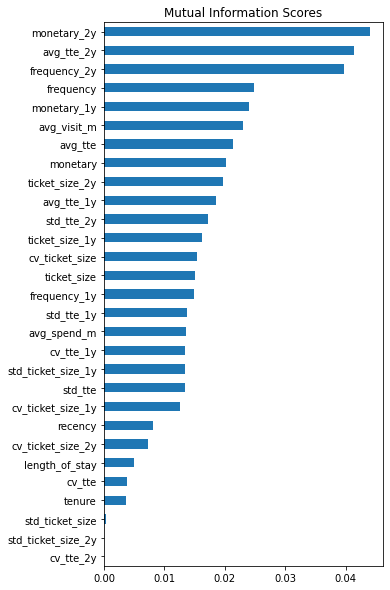

In [52]:
mi_scores = get_mi_scores(X_train, y_train)
plot_mi_scores(mi_scores, (5,10))

In [53]:
mi_scores > 0

monetary_2y            True
avg_tte_2y             True
frequency_2y           True
frequency              True
monetary_1y            True
avg_visit_m            True
avg_tte                True
monetary               True
ticket_size_2y         True
avg_tte_1y             True
std_tte_2y             True
ticket_size_1y         True
cv_ticket_size         True
ticket_size            True
frequency_1y           True
std_tte_1y             True
avg_spend_m            True
cv_tte_1y              True
std_ticket_size_1y     True
std_tte                True
cv_ticket_size_1y      True
recency                True
cv_ticket_size_2y      True
length_of_stay         True
cv_tte                 True
tenure                 True
std_ticket_size        True
std_ticket_size_2y    False
cv_tte_2y             False
Name: MI Scores, dtype: bool

# Model Experiment

## Feature Sets

Feature sets for experiments:
- `All` Features
- `RFM` Only RFM features
- `LTD` Life-To-Date features not including Past-X-Year features
- `SET1` drop features with no or low Mutual Information scores

In [54]:
# All Features
feature_set_all = X.columns

# Only RFM Features
feature_set_rfm = ['recency', 'frequency', 'monetary']

# LTD features - not using Past-X-Year features
feature_set_ltd = ['recency','frequency','monetary','tenure','length_of_stay',
                   'ticket_size','std_ticket_size','cv_ticket_size',
                   'avg_spend_m','avg_visit_m','avg_tte','std_tte','cv_tte']
                   
# Drop some features considering MI scores
feature_set_1 = X.drop(columns=['cv_tte_2y','std_ticket_size_2y','std_ticket_size', 'tenure', 'cv_tte']).columns


## Utility functions

In [56]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=6, random_state=random_state)

In [55]:
# Utility Classes
class ModelEvaluation:
    def __init__(self, estimator, params={}, fit_params={}, random_state=0):
        self.estimator = estimator
        self.params = params
        self.fit_params = fit_params
        self.random_state = random_state

    def train(self, X_train, y_train, **fit_kws):
        model = self.estimator(random_state=self.random_state, **self.params)
        model.fit(X_train, y_train, **self.fit_params, **fit_kws)
        return model

    def eval(self, X_train, y_train, X_test, y_test):
        model = self.train(X_train, y_train)
        auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        return auc_train, auc_test

    def eval_cv(self, X, y, X_test, y_test, cv):
        train_scores, val_scores = [], []
        for train_idx, val_idx in cv.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
            auc_train, auc_val = self.eval(X_train, y_train, X_val, y_val)
            train_scores.append(auc_train)
            val_scores.append(auc_val)
        _, auc_test = self.eval(X, y, X_test, y_test)
        return { 'cv_val_mean' : np.mean(val_scores), 'cv_val_std'  : np.std(val_scores),
                 'cv_train_mean' : np.mean(train_scores), 'cv_train_std' : np.std(train_scores),
                 'train_scores' : train_scores, 'val_scores' : val_scores,
                 'test_score' : auc_test
               }

class GBModelEvaluation(ModelEvaluation):
    def eval(self, X_train, y_train, X_test, y_test):
        model = self.train(X_train, y_train, eval_set=[(X_test, y_test)])
        auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        return auc_train, auc_test

# Display Formatted Experiment Result
def display_experiments(results):
    df = pd.DataFrame.from_dict(results, orient='index')
    df = df[['cv_val_mean','cv_val_std','cv_train_mean','cv_train_std','test_score']]
    df = df.sort_values(['cv_val_mean'], ascending=False)
    return df.style.bar(subset=['cv_val_mean'], color='forestgreen')\
                    .bar(subset=['cv_train_mean'], color='deepskyblue')\
                    .bar(subset=['cv_train_std','cv_val_std'], color='slategray')\
                    .bar(subset=['test_score'], color='salmon')

## RandomForest

In [57]:
experiment_names = ['RandomForest-ALL', 'RandomForest-RFM', 'RandomForest-LTD', 'RandomForest-SET1']
feature_sets = [feature_set_all, feature_set_rfm, feature_set_ltd , feature_set_1 ]

rf_params = {
    'bootstrap': True,
    'criterion': 'entropy',
    'max_depth' : 5,
    'max_features' : 'auto'
}

rf_results = {}
rf_eval = ModelEvaluation(RandomForestClassifier, params=rf_params, random_state=random_state)
for name, features in zip(experiment_names, feature_sets):
    result = rf_eval.eval_cv(X_train[features], y_train, X_test[features], y_test, kfold)
    rf_results[name] = result

display_experiments(rf_results)

,cv_val_mean,cv_val_std,cv_train_mean,cv_train_std,test_score
RandomForest-SET1,0.788448,0.018951,0.878866,0.003085,0.794903
RandomForest-ALL,0.787291,0.018445,0.883570,0.002851,0.794263
RandomForest-LTD,0.730021,0.021255,0.842661,0.002990,0.753646
RandomForest-RFM,0.729896,0.021646,0.804458,0.005156,0.752696


## ExtraTrees

In [58]:
experiment_names = ['ExtraTrees-ALL', 'ExtraTrees-RFM', 'ExtraTrees-LTD', 'ExtraTrees-SET1']
feature_sets = [feature_set_all, feature_set_rfm, feature_set_ltd, feature_set_1 ]

xt_params = {
    'bootstrap' : True,
    'criterion' : 'entropy',
    'max_depth' : 7,
}
xt_results = {}
xt_eval = ModelEvaluation(ExtraTreesClassifier, params=xt_params, random_state=random_state)
for name, features in zip(experiment_names, feature_sets):
    result = xt_eval.eval_cv(X_train[features], y_train, X_test[features], y_test, kfold)
    xt_results[name] = result

display_experiments(xt_results)

,cv_val_mean,cv_val_std,cv_train_mean,cv_train_std,test_score
ExtraTrees-SET1,0.778675,0.020850,0.860888,0.003493,0.775380
ExtraTrees-ALL,0.778454,0.020733,0.870673,0.003224,0.782983
ExtraTrees-LTD,0.726506,0.022088,0.808990,0.003833,0.737105
ExtraTrees-RFM,0.725369,0.020445,0.767896,0.004527,0.745000


## XGBoost

In [59]:
# XGBoost parameter to handle imbalance problem
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
scale_pos_weight

9.63127413127413

In [60]:
experiment_names = ['XGBoost-ALL', 'XGBoost-RFM', 'XGBoost-LTD', 'XGBoost-SET1']
feature_sets = [feature_set_all, feature_set_rfm, feature_set_ltd, feature_set_1 ]

xgb_params = {'objective': 'binary:logistic', 
              'eval_metric': 'auc',
              'scale_pos_weight' : scale_pos_weight, 
              'use_label_encoder' : False,
              'n_estimators' : 1000,
              'max_depth' : 4,
              'subsample' : .95,
              'colsample_bytree' : .95,
              'colsample_bylevel' : .95,
              }
xgb_fit_params = { 'early_stopping_rounds' : 10, 'verbose' : False }

xgb_results = {}
xgb_eval = GBModelEvaluation(xgb.XGBClassifier, params=xgb_params, fit_params=xgb_fit_params, random_state=random_state)
for name, features in zip(experiment_names, feature_sets):
    result = xgb_eval.eval_cv(X_train[features], y_train, X_test[features], y_test, kfold)
    xgb_results[name] = result

display_experiments(xgb_results)

,cv_val_mean,cv_val_std,cv_train_mean,cv_train_std,test_score
XGBoost-SET1,0.792025,0.019659,0.856242,0.018450,0.798782
XGBoost-ALL,0.790581,0.018480,0.861804,0.014436,0.799943
XGBoost-RFM,0.732119,0.020248,0.774130,0.014092,0.753072
XGBoost-LTD,0.730570,0.020716,0.818621,0.029961,0.750702


## LightGBM

In [61]:
experiment_names = ['LightGBM-ALL', 'LightGBM-RFM', 'LightGBM-LTD', 'LightGBM-SET1']
feature_sets = [feature_set_all, feature_set_rfm, feature_set_ltd, feature_set_1 ]

lgb_params = {
    'objective': 'binary', 
    'is_unbalance': 'true', 
    'metric': 'auc',
    'feature_fraction' : 0.9,
    'learning_rate' : 0.03,
    'num_leaves' : 12,
    'verbose': 0,
}
lgb_fit_params = {'early_stopping_rounds': 10, 'verbose': 0 }
lgb_results = {}
lgb_eval = GBModelEvaluation(lgb.LGBMClassifier, params=lgb_params, fit_params=lgb_fit_params, random_state=random_state)
for name, features in zip(experiment_names, feature_sets):
    result = lgb_eval.eval_cv(X_train[features], y_train, X_test[features], y_test, kfold)
    lgb_results[name] = result

display_experiments(lgb_results)

,cv_val_mean,cv_val_std,cv_train_mean,cv_train_std,test_score
LightGBM-SET1,0.791914,0.019136,0.850798,0.010832,0.800049
LightGBM-ALL,0.790958,0.018819,0.852665,0.011741,0.796434
LightGBM-RFM,0.729782,0.023909,0.775634,0.010107,0.755326
LightGBM-LTD,0.729707,0.020799,0.802026,0.012573,0.761178


## Result Comparison

In [62]:
model_results = {}
for result in [rf_results, xt_results, xgb_results, lgb_results]:
    model_results.update(result)

display_experiments(model_results)

,cv_val_mean,cv_val_std,cv_train_mean,cv_train_std,test_score
XGBoost-SET1,0.792025,0.019659,0.856242,0.018450,0.798782
LightGBM-SET1,0.791914,0.019136,0.850798,0.010832,0.800049
LightGBM-ALL,0.790958,0.018819,0.852665,0.011741,0.796434
XGBoost-ALL,0.790581,0.018480,0.861804,0.014436,0.799943
RandomForest-SET1,0.788448,0.018951,0.878866,0.003085,0.794903
RandomForest-ALL,0.787291,0.018445,0.883570,0.002851,0.794263
ExtraTrees-SET1,0.778675,0.020850,0.860888,0.003493,0.775380
ExtraTrees-ALL,0.778454,0.020733,0.870673,0.003224,0.782983
XGBoost-RFM,0.732119,0.020248,0.774130,0.014092,0.753072
XGBoost-LTD,0.730570,0.020716,0.818621,0.029961,0.750702


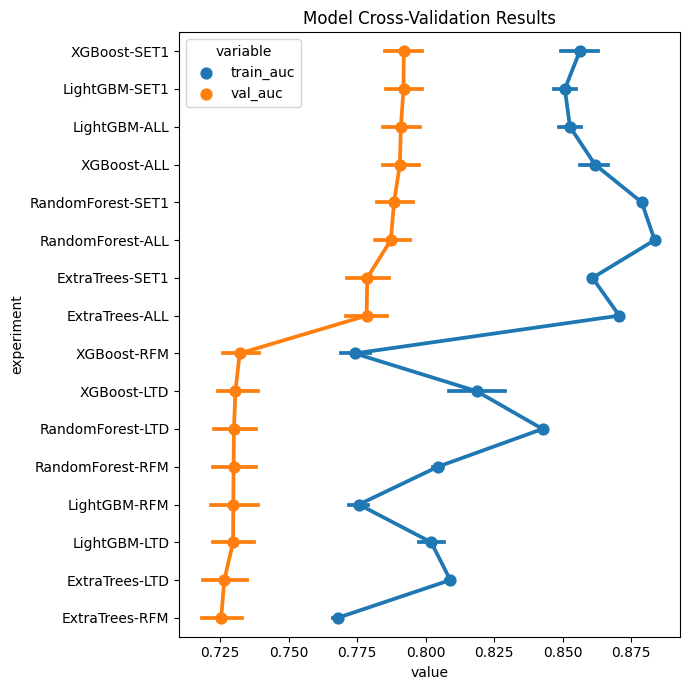

In [65]:
perf = pd.DataFrame.from_dict(model_results, orient='index').sort_values('cv_val_mean', ascending=False)
concat_list = []
for exp in perf.index:
    temp = pd.DataFrame({ 'train_auc': model_results[exp]['train_scores'],
           'val_auc' : model_results[exp]['val_scores']})
    temp['experiment'] = exp
    concat_list.append(temp)

df_scores = pd.concat(concat_list)
df_scores = df_scores.melt('experiment')

plt.figure(figsize=(7,7), tight_layout=True, dpi=100)
sns.pointplot(data=df_scores, x='value', y='experiment', hue='variable')
plt.title('Model Cross-Validation Results')
# plt.savefig('result.png')
plt.show()

**Final Notes**

- `RFM` feature set yield much worst result
- `LTD` feature set has more features than RFM. Life-To-Date features such as monetary or frequency are generated using the whole data. This improves the performance a bit from RFM set.
- Seeing that `SET1` and `ALL` feature sets have much better performance means that the features generated using data from past 1 year, and 2 years helps.

- This demonstrates the power of `feature engineering`. Even though, we only have `transaction amount` data, but with different aggregation techniques, we can raise our model performance.

- We may shortlist `XGBoost` and `LightGBM` for further steps like, Hyperparameter tuning, or experimenting with resampling techniques such as under-sampling, over-sampling, or SMOTE, etc.
